# 1. Introduction

Using Foursquare's data about cultural events and places, It's possible to group similar events and create several touristic trips around a specific city for people with different tastes using machine learning. As a first iteration of the idea, we could get the data from museums, concert halls, live theaters,  expos, etc. and group them using k-means based on the content of each event, and offer thematic touristic services around those events.

As a proof of concept, this notebook will get data from museums, music venues and stadiums from Mexico City

#  2. Data 
- Name of the venue
- Location ( latitude, longitude)
- Category (see `validCategories` for the set of valid categories relevant to this analysis)

## 2.1 Data Collection
All of the data comes from the Foursquare location API.

## 2.2 Data Cleaning
Most of the data given by Foursquare isn't relevant for this notebook's purpose, like iD and hasPerk, so the only columns we're interested are: name, latitude, longitude and categories.

In the case of **latitude** and **longitude**, both of them are in the **location** column, along with **address**, **postalCode** and some more irrelevant info. That's why one of the things to do is writing only the latitude in one column, the longitude in another column, and dispose the original **location** column.

The **categories** column needs reformatting, because it's given by a list, containing a JSON with additional data (see **Example of Data Before Cleaning**), and we're only interested in the categories' **name** value.

To fix the **location** and **categories** formatting issue, this notebook contains the functions `getLatLonAndCategories(df)` and `process(df)`.

Sometimes the venue doesn't contain all of the relevant information. In such cases, the venue will be removed from the dataset.

Due to the API's limit of 50 results per query, there's a need to make several queries, with some differences (i.e. "museum", "history museum", "national museum", etc) and adding only the results that aren't already in the final DataFrame. Using Foursquare's free plan, one can only make 950 API calls / day, so the upper bound of venues we can have is 47500 * ( number of days dedicated to data collection). In this case, we will limit the number of days to 1.


### 2.2.1 Example of data before cleaning <a name="unclean-df"></a>

In [350]:
testQuery=lastQuery
print("Raw location sample: \n\n",testQuery["location"][0],"\n\n")
print("Raw categories sample: \n\n",testQuery["categories"][0],"\n\n")
print("Raw dataframe sample: ")
testQuery.head(10)

Raw location sample: 

 {'lat': 19.429249, 'lng': -99.132217, 'labeledLatLngs': [{'label': 'display', 'lat': 19.429249, 'lng': -99.132217}], 'postalCode': '06060', 'cc': 'MX', 'city': 'Mexico City', 'state': 'CDMX', 'country': 'México', 'formattedAddress': ['06060 Mexico City, CDMX', 'México']} 


Raw categories sample: 

 [{'id': '4bf58dd8d48988d181941735', 'name': 'Museum', 'pluralName': 'Museums', 'shortName': 'Museum', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/museum_', 'suffix': '.png'}, 'primary': True}] 


Raw dataframe sample: 


,name,location,categories
0,museum of mexico,"{'lat': 19.429249, 'lng': -99.132217, 'labeled...","[{'id': '4bf58dd8d48988d181941735', 'name': 'M..."
1,British American Museum,"{'address': 'Artículo 123 #134', 'crossStreet'...","[{'id': '4bf58dd8d48988d190941735', 'name': 'H..."
2,Museum Office Desk Restaurant AC,"{'address': 'Puente De Alvarado 50', 'lat': 19...","[{'id': '4bf58dd8d48988d16e941735', 'name': 'F..."
3,Museum,"{'lat': 19.392358779907227, 'lng': -99.1806106...","[{'id': '4bf58dd8d48988d125941735', 'name': 'T..."
4,Museum aan de stroom,"{'lat': 19.414180755615234, 'lng': -99.0852966...","[{'id': '4bf58dd8d48988d190941735', 'name': 'H..."
5,san francisco museum of modern art,"{'lat': 19.436758370529315, 'lng': -99.0803090...","[{'id': '4bf58dd8d48988d18f941735', 'name': 'A..."
6,Agneviking Aviation Museum,"{'lat': 19.46644, 'lng': -99.16826, 'labeledLa...","[{'id': '4bf58dd8d48988d190941735', 'name': 'H..."
7,Museo Soumaya,"{'address': 'Plaza Carso', 'crossStreet': 'Lag...","[{'id': '4bf58dd8d48988d18f941735', 'name': 'A..."
8,Sci museum,"{'lat': 19.376053, 'lng': -99.159014, 'labeled...","[{'id': '4bf58dd8d48988d191941735', 'name': 'S..."
9,Museum,"{'address': 'Aristóteles 8', 'lat': 19.4283640...","[{'id': '4bf58dd8d48988d114951735', 'name': 'B..."


### 2.2.2 Example of data after cleaning

In [351]:
process(testQuery)

,name,Category,Latitude,Longitude
0,museum of mexico,Museum,19.429249,-99.132217
1,British American Museum,History Museum,19.432746,-99.150288
2,Museum Office Desk Restaurant AC,Fast Food Restaurant,19.438410,-99.151688
3,Museum,Tech Startup,19.392359,-99.180611
4,Museum aan de stroom,History Museum,19.414181,-99.085297
5,san francisco museum of modern art,Art Museum,19.436758,-99.080309
6,Agneviking Aviation Museum,History Museum,19.466440,-99.168260
7,Museo Soumaya,Art Museum,19.440401,-99.204482
8,Sci museum,Science Museum,19.376053,-99.159014
9,Museum,Bookstore,19.428364,-99.193856


# 3. Methodology

First we're going to import some needed packages

In [483]:
#IMPORTS BLOCK
import numpy as np
import requests
import pandas as pd
import folium
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

## 3.1 Saving / Loading Data
The following blocks are used to save and load the data in `savedVenues.csv`, for minimizing the Foursquare API calls needed to get the data between several sesions. The first block tries to load the CSV and in case it isn't found, creates a new DataFrame.
The second block saves the `totalVenues` dataFrame in `savedVenues.csv` for future access.

In [498]:
# LOAD DATA
try:
    totalVenues= pd.read_csv("./savedVenues.csv")
except:
    totalVenues=pd.DataFrame()

In [502]:
# SAVE VANUES TO CSV
totalVenues.to_csv("./savedVenues.csv")

## 3.2  Send query to Foursquare API

This project is using Foursquare API to get the necesary information of each venue.
To use this block, the user needs to enter the Foursquare Client ID and Client Secret in the respective variables, and use the `query` variable to search for venues.
The result will be saved in the `lastQuery` variable as a [DataFrame](#unclean-df)

In [473]:
# QUERIES

v=20190425
client_id="======ENTER YOUR FOURSQUARE CLIENT ID======"
client_secret="======ENTER YOUR FOURSQUARE CLIENT SECRET======"
limit=50


#==============
query="music"
#==============

url="https://api.foursquare.com/v2/venues/search?client_id="+client_id+"&client_secret="+client_secret+"&v="+str(v)+"&near=mexico city&intent=browse&radius=10000&query="+query+"&limit="+str(limit)
a=requests.get(url).json()
data=a["response"]
_=pd.DataFrame(data["venues"])
_=_[["name","location","categories"]]
lastQuery=_
print("Done with query: ",query)

Done with query:  music


In [474]:
process(lastQuery)

,name,Category,Latitude,Longitude
0,Music Club,Music Venue,19.428803,-99.138995
1,Karma music,Music Store,19.429424,-99.139001
2,Music City Coffee,Café,19.428655,-99.137100
3,Tokyo Music Bar,Cocktail Bar,19.429480,-99.169495
4,Universal Music,Office,19.433230,-99.168736
5,Taxicab Music Group,Recording Studio,19.429859,-99.156514
6,The Contemporary Music School,College Arts Building,19.370542,-99.174466
7,Hermes Music,Music Store,19.446046,-99.159281
8,Romma music club,Music Venue,19.416286,-99.165196
9,Music City,Music Store,19.429464,-99.138967


In [499]:
# ADD LAST QUERY TO TOTAL VENUES
totalVenues=totalVenues.append(process(lastQuery),ignore_index=True)
totalVenues=cleanTotalVenues(totalVenues).reset_index(drop=True)
totalVenues.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,Category,Latitude,Longitude,Unnamed: 0,name
0,Museum,19.429249,-99.132217,0.0,museum of mexico
1,History Museum,19.432746,-99.150288,1.0,British American Museum
2,History Museum,19.414181,-99.085297,2.0,Museum aan de stroom
3,Art Museum,19.436758,-99.080309,3.0,san francisco museum of modern art
4,History Museum,19.466440,-99.168260,4.0,Agneviking Aviation Museum


## 3.3. Use K-means to cluster the venues by location
- First of all, the location data of each venue needs to be normalized (i.e, the left-most location will have a longitude value of 0, the right-most a longitude of 1. Similarly for the latitude.)
- Once the data has been normalize, we will find the best k for k-means using the elbow method.
- In this case we found that the best k is 5 (see plot below)
- Now that we have the k, we can compute the clusters and add the label of the cluster to the `totalVenues` DataFrame as a new column. That new DataFrame is now called `labeledVenues`.

array([2, 2, 1, 1, 4, 0, 3, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 1, 2, 2, 3,
       2, 2, 2, 0, 2, 2, 2, 3, 2, 0, 4, 1, 0, 2, 3, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 3, 3, 3, 2, 0, 2,
       2, 0, 2, 1, 2, 3, 3, 3, 2, 2, 2, 2, 0, 0, 0, 3, 1, 1, 0, 1, 4, 0,
       2, 0, 2, 0, 4, 2, 1, 2, 2, 2], dtype=int32)

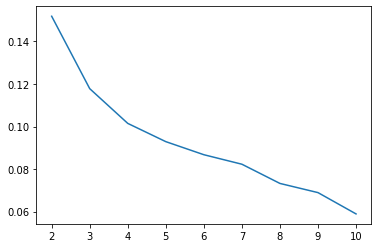

In [512]:
#TEST kmeans for 2-10 clusters to search for the elbow
X=normalizeLatLon()
scores=[]
scores2=[]
for i in range(2,11):
    km=KMeans(n_clusters=i).fit(X)
    scores.append(sum(np.min(cdist(X, km.cluster_centers_, 'euclidean'), axis=1)) / len(X))
    scores2.append(abs(km.score(X)))
    
    
plt.plot(range(2,11),scores)


#BEST K =5
km=KMeans(n_clusters=5).fit(X)
km.labels_

In [513]:
labeledVenues=totalVenues.assign(Labels=km.labels_)
labeledVenues.head()

,Category,Latitude,Longitude,Unnamed: 0,name,Labels
0,Museum,19.429249,-99.132217,0.0,museum of mexico,2
1,History Museum,19.432746,-99.150288,1.0,British American Museum,2
2,History Museum,19.414181,-99.085297,2.0,Museum aan de stroom,1
3,Art Museum,19.436758,-99.080309,3.0,san francisco museum of modern art,1
4,History Museum,19.466440,-99.168260,4.0,Agneviking Aviation Museum,4


## 3.4. Plot the data into a map
Using `labeledVenues` we can plot each venue in a map, color-coding each marker, and setting it's icon based on the venues' category

In [515]:
# DRAW MAP
mapa= folium.Map(location=[labeledVenues["Latitude"].median(),labeledVenues["Longitude"].median()],zoom_start=12)

for index, row in labeledVenues.iterrows():
    folium.Marker(
    [row["Latitude"],row["Longitude"]],
    popup=row["name"],
    icon=folium.Icon(color=labelColors[row["Labels"]],icon=iconCategories[row["Category"]],prefix="fa")
).add_to(mapa)
    
mapa


# 4. Results and Discussion
The original purpose of this notebook was to group together venues with similar events, but due to the difficulty of getting proper information of each venue (what type of events, how many events are in a single venue) , and the fact that most of the events are time sensitive, there wasn't a way to quantify most characteristics of each venue. The first thing I thought I could do was to make an `Interactive` attribute of each venue, and normalize it (i.e. 0 for entirely non-interactive experience and 1 for totally-interactive experiences, like some events and workshops in a culture center. Other attributes I thought I could use were `Visual`, `Auditory` and `Modernity`.
Using those 4 attributes, together with the `Latitude` and `Longitude`, previously normalized, we were suposed to get a 6-dimensional vector, and use it for clustering with k-means, to group similar venues together.
The problem with this idea, is that getting enough information of each event automatically, because almost each event has it's own information formatted entirely in different way. That's why the only information fed into the k-means algorythm is just the Latitude and the Longitude of each venue.

# 5. Conclusion
The resulting clusters almost every time divides Mexico City into: Downtown (center), North, South, East and West naturally.
I find that interesting because the data doesn't contain information about different districts of Mexico City, yet almost every time, there won't be districts with two or more cluster.


# 6. Appendix: Auxiliar Functions

In [372]:
# AUX FUNCTIONS

def getLatLonAndCategories(dataFrame):
    location=pd.Series(dataFrame["location"])
    category=pd.Series(dataFrame["categories"])
    latitude=[]
    longitude=[]
    names=[]
    for i in location:
        _=dict(i)
        latitude.append(_["lat"])
        longitude.append(_["lng"])
    
    for i in category:
        if len(i)>0:
            _=dict(i[0])
            names.append(_["name"])
        else:
            names.append("Not Available")
    return (latitude, longitude,names)



def process(lastQuery_df):
    newData=getLatLonAndCategories(lastQuery_df)
    _=lastQuery_df.assign(Latitude=newData[0],Longitude=newData[1], Category=newData[2])
    _=_[["name","Category", "Latitude", "Longitude"]]
    return _
    
def cleanTotalVenues(totalVenues_df):
    totalVenues_df=totalVenues_df.drop_duplicates(subset=["name","Category"])
    totalVenues_df=totalVenues_df[totalVenues_df["Category"].isin(validCategories)]
    return totalVenues_df

def normalizeLatLon():
    couples=[]
    lat=totalVenues["Latitude"]
    lon=totalVenues["Longitude"]
    latitudeNorm=list((lat-lat.min())/(lat.max()-lat.min()))
    longitudeNorm=list(abs(lon-lon.min())/(lat.max()-lat.min()))
    for i in range(len(latitudeNorm)):
        couples.append([latitudeNorm[i],longitudeNorm[i]])
    
    return couples

In [463]:
validCategories={"Museum",
                 "History Museum", 
                 "Art Museum", 
                 "Science Museum", 
                 "Monument / Landmark",
                 "Auditorium",
                 "Art Gallery",
                 "Opera House",
                 "Indie Movie Theater",
                 "Public Art",
                 "General Entretainment",
                 "Cultural Center",
                 "Music Venue",
                 "Historic Site",
                 "Exhibit",
                 "Convention Center",
                 "Soccer Stadium"
                }

labelColors=["red", "blue", "green","purple","orange"]


iconCategories={ "Museum": "university",
                 "History Museum": "university", 
                 "Art Museum" :"paint-brush" ,
                 "Science Museum":"flask", 
                 "Monument / Landmark" : "university",
                 "Auditorium":"music",
                 "Art Gallery":"paint-brush",
                 "Opera House":"music",
                 "Indie Movie Theater":"film",
                 "Public Art":"paint-brush",
                 "General Entretainment":"male",
                 "Cultural Center":"male",
                 "Music Venue":"music",
                 "Historic Site":"flag",
                 "Exhibit":"eye",
                "Convention Center":"users",
                "Soccer Stadium":"futbol-o"
    
}

In [501]:
len(totalVenues)

98